# Test Segmentation-Model Libary

In [80]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import os,glob,cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
import numpy as np
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset
from segmentation_models_pytorch.metrics import iou_score
from segmentation_models_pytorch.utils import train,losses,metrics
import torch

### Dataset link : https://mm.cs.uec.ac.jp/uecfoodpix/

In [71]:
DATA_ROOT = r'D:\Work\Paper-Works\UEC-FoodPix\Data\UECFOODPIXCOMPLETE\data\UECFoodPIXCOMPLETE'
category_txt = r'D:\Work\Paper-Works\UEC-FoodPix\Data\UECFOODPIXCOMPLETE\data\category.txt'
train_names_txt = r'D:\Work\Paper-Works\UEC-FoodPix\Data\UECFOODPIXCOMPLETE\data\train9000.txt'
test_names_txt = r'D:\Work\Paper-Works\UEC-FoodPix\Data\UECFOODPIXCOMPLETE\data\test1000.txt'

train_image_folder = os.path.join(DATA_ROOT, 'train', 'img')
train_mask_folder = os.path.join(DATA_ROOT, 'train', 'mask')
test_image_folder = os.path.join(DATA_ROOT, 'test', 'img')
test_mask_folder = os.path.join(DATA_ROOT, 'test', 'mask')

_CLASSES = ['rice','eels on rice','pilaf', "chicken-'n'-egg on rice", 'pork cutlet on rice', 'beef curry', 'sushi', 'chicken rice', 'fried rice', 'tempura bowl',
               'bibimbap','toast','croissant','roll bread','raisin bread','chip butty','hamburger','pizza','sandwiches','udon noodle','tempura udon','soba noodle',
               'ramen noodle','beef noodle','tensin noodle','fried noodle','spaghetti','Japanese-style pancake','takoyaki','gratin','sauteed vegetables','croquette',
               'grilled eggplant','sauteed spinach','vegetable tempura','miso soup','potage','sausage','oden','omelet','ganmodoki','jiaozi','stew','teriyaki grilled fish',
               'fried fish','grilled salmon','salmon meuniere','sashimi','grilled pacific saury','sukiyaki','sweet and sour pork','lightly roasted fish',
               'steamed egg hotchpotch','tempura','fried chicken','sirloin cutlet','nanbanzuke','boiled fish','seasoned beef with potatoes','hambarg steak','beef steak',
               'dried fish','ginger pork saute','spicy chili-flavored tofu','yakitori','cabbage roll','rolled omelet','egg sunny-side up','fermented soybeans','cold tofu',
               'egg roll','chilled noodle','stir-fried beef and peppers','simmered pork','boiled chicken and vegetables','sashimi bowl','sushi bowl','fish-shaped pancake with bean jam',
               'shrimp with chill source','roast chicken','steamed meat dumpling','omelet with fried rice','cutlet curry','spaghetti meat sauce','fried shrimp','potato salad',
               'green salad','macaroni salad','Japanese tofu and vegetable chowder','pork miso soup','chinese soup','beef bowl','kinpira-style sauteed burdock','rice ball',
               'pizza toast','dipping noodles','hot dog','french fries','mixed rice','goya chanpuru','others','beverage']

In [72]:
# helper function for data visualization

def visualize(image,mask):
    cls_info = [np.unique(mask[:,:,i]) for i in range(mask.shape[2])]
    cls_info_det = [indx for indx,i in enumerate(cls_info) if i.shape[0]>1]
    cls_present = [_CLASSES[i] for i in cls_info_det]
    print(cls_info_det)
    print(cls_present)
    plt.figure(figsize=(20,20))
    for i in range(len(cls_info_det)+1):
        plt.subplot(len(cls_info_det)//2+1,2,i+1)
        if i==0:
            plt.imshow(image)
        else:
            plt.imshow(image)
            indx = cls_info_det[i-1]
            plt.imshow(mask[:,:,indx],alpha=0.45,cmap='seismic')
            plt.title(cls_present[i-1])
    plt.tight_layout()
    plt.axis('off')
plt.show() 

class Dataset(BaseDataset):
    """UEC Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    CLASSES = ['rice','eels on rice','pilaf', "chicken-'n'-egg on rice", 'pork cutlet on rice', 'beef curry', 'sushi', 'chicken rice', 'fried rice', 'tempura bowl',
               'bibimbap','toast','croissant','roll bread','raisin bread','chip butty','hamburger','pizza','sandwiches','udon noodle','tempura udon','soba noodle',
               'ramen noodle','beef noodle','tensin noodle','fried noodle','spaghetti','Japanese-style pancake','takoyaki','gratin','sauteed vegetables','croquette',
               'grilled eggplant','sauteed spinach','vegetable tempura','miso soup','potage','sausage','oden','omelet','ganmodoki','jiaozi','stew','teriyaki grilled fish',
               'fried fish','grilled salmon','salmon meuniere','sashimi','grilled pacific saury','sukiyaki','sweet and sour pork','lightly roasted fish',
               'steamed egg hotchpotch','tempura','fried chicken','sirloin cutlet','nanbanzuke','boiled fish','seasoned beef with potatoes','hambarg steak','beef steak',
               'dried fish','ginger pork saute','spicy chili-flavored tofu','yakitori','cabbage roll','rolled omelet','egg sunny-side up','fermented soybeans','cold tofu',
               'egg roll','chilled noodle','stir-fried beef and peppers','simmered pork','boiled chicken and vegetables','sashimi bowl','sushi bowl','fish-shaped pancake with bean jam',
               'shrimp with chill source','roast chicken','steamed meat dumpling','omelet with fried rice','cutlet curry','spaghetti meat sauce','fried shrimp','potato salad',
               'green salad','macaroni salad','Japanese tofu and vegetable chowder','pork miso soup','chinese soup','beef bowl','kinpira-style sauteed burdock','rice ball',
               'pizza toast','dipping noodles','hot dog','french fries','mixed rice','goya chanpuru','others','beverage']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,):
        
        self.ids = os.listdir(images_dir)
        self.ids = [os.path.splitext(i)[0] for i in self.ids]
        self.images_fps = [os.path.join(images_dir, image_id + '.jpg') for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id + '.png') for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) + 1 for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # Read Data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i])[:,:,-1]
        
        # extract certain classes from mask 
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        # apply augmentations
        
        if type(self.augmentation) != type(None):
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [73]:
im_w = 320
im_h = 320

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.1, 
                              rotate_limit=0.4, 
                              shift_limit=0.1, 
                              p=0.4, 
                              border_mode=0),
        
        albu.PadIfNeeded(min_height=im_h,
                         min_width=im_w, 
                         always_apply=True, 
                         border_mode=0),
        
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.3),
        
        albu.OneOf([albu.CLAHE(p=1),
                    albu.RandomBrightness(p=1),
                    albu.RandomGamma(p=1)],
                   p=0.6),
        albu.OneOf([albu.IAASharpen(p=1),
                    albu.Blur(blur_limit=3, p=1),
                    albu.MotionBlur(blur_limit=3, p=1)],
                   p=0.6),
        albu.OneOf([albu.RandomContrast(p=1),
                    albu.HueSaturationValue(p=1)],p=0.6),
        albu.Resize(height=im_h,width=im_w,always_apply=True)]
    
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.PadIfNeeded(min_height=im_h,
                                       min_width=im_w, 
                                       always_apply=True, 
                                       border_mode=0),
                      albu.Resize(height=im_h,width=im_w,always_apply=True)] #should be divisible by 32
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [75]:
#### Visualize resulted augmented images and masks
augmented_dataset_train = Dataset(train_image_folder, 
                            train_mask_folder, 
                            classes=_CLASSES,
                            augmentation=get_training_augmentation())

augmented_dataset_test = Dataset(test_image_folder, 
                            test_mask_folder, 
                            classes=_CLASSES,
                            augmentation=get_validation_augmentation())


102
(320, 320, 3) (320, 320, 102)
[12]
['croissant']


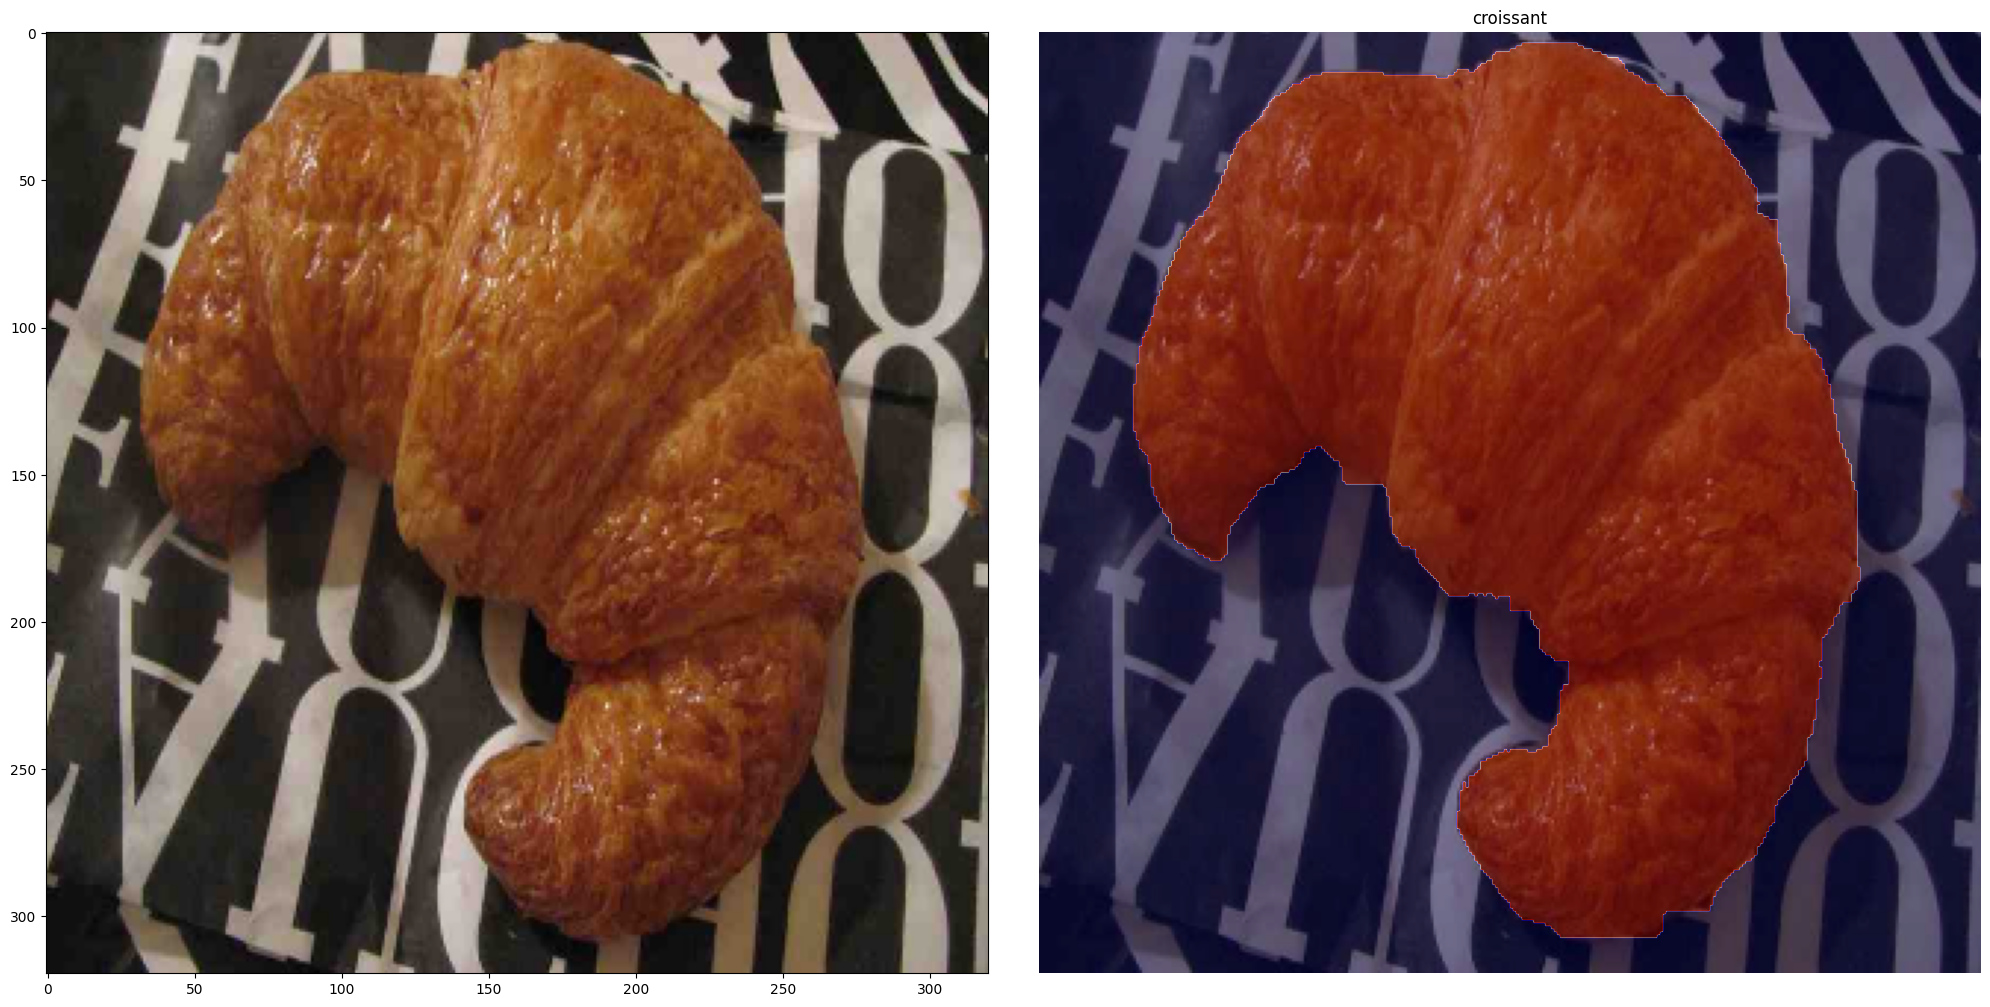

In [76]:
# same image with different random transforms
ns = np.random.randint(0,990)
print(ns)
image, mask = augmented_dataset_test[ns] # get some sample
print(image.shape,mask.shape)
visualize(image,mask)

In [77]:
# Model

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = _CLASSES
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, 
                                                     ENCODER_WEIGHTS)

In [78]:
train_dataset = Dataset(train_image_folder, 
                        train_mask_folder,
                        augmentation=get_training_augmentation(), 
                        preprocessing=get_preprocessing(preprocessing_fn),
                        classes=_CLASSES)

valid_dataset = Dataset(test_image_folder, 
                        test_mask_folder, 
                        augmentation=get_validation_augmentation(), 
                        preprocessing=get_preprocessing(preprocessing_fn),
                        classes=_CLASSES)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)#, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)#, num_workers=4)

In [79]:
print(len(train_loader))
print(len(valid_loader))

1500
1000


In [11]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = _CLASSES
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

model = smp.FPN(encoder_name=ENCODER, 
                encoder_weights=ENCODER_WEIGHTS, 
                classes=len(_CLASSES), 
                activation=ACTIVATION)

In [13]:
loss = losses.DiceLoss()

metrics = [
    metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [14]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [15]:
# train model for 40 epochs

max_score = 0

for i in range(0, 3):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 1000/1000 [15:59<00:00,  1.04it/s, dice_loss - 0.8332, iou_score - 0.122] 
Model saved!

Epoch: 1
valid: 100%|██████████| 1000/1000 [14:28<00:00,  1.15it/s, dice_loss - 0.7991, iou_score - 0.1545]
Model saved!

Epoch: 2
valid: 100%|██████████| 1000/1000 [16:25<00:00,  1.01it/s, dice_loss - 0.7942, iou_score - 0.1578]
Model saved!


# Training with Catalyst

In [50]:
import catalyst
from catalyst import utils
from catalyst import metrics
from catalyst.contrib.losses import DiceLoss, IoULoss
import torch
from torch import nn
import numpy as np
import segmentation_models_pytorch as smp
import yaml
from yaml.loader import SafeLoader
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader
import os,glob,cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu

SEED = 42
utils.set_global_seed(SEED)
utils.prepare_cudnn(deterministic=True)

print(f"torch: {torch.__version__}, catalyst: {catalyst.__version__}")

def load_yaml(yaml_path):
    with open(yaml_path) as f:
        data = yaml.load(f,Loader=SafeLoader)
    return data

torch: 1.12.1+cu116, catalyst: 22.04


# Load dataset details, Make Dataset Class & Dataloader class

In [56]:
dataset_details = load_yaml(r'dataset_details.yaml')

data_root = dataset_details['DATA_ROOT']
category_txt = dataset_details['category_txt']
train_names_txt = dataset_details['train_names_txt']
test_names_txt = dataset_details['test_names_txt']
CLASSES = dataset_details['CLASSES']

train_image_folder = os.path.join(data_root, 'train', 'img')
train_mask_folder = os.path.join(data_root, 'train', 'mask')
test_image_folder = os.path.join(data_root, 'test', 'img')
test_mask_folder = os.path.join(data_root, 'test', 'mask')

im_w = 320
im_h = 320

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.1, 
                              rotate_limit=0.4, 
                              shift_limit=0.1, 
                              p=0.4, 
                              border_mode=0),
        
        albu.PadIfNeeded(min_height=im_h,
                         min_width=im_w, 
                         always_apply=True, 
                         border_mode=0),
        
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.3),
        
        albu.OneOf([albu.CLAHE(p=1),
                    albu.RandomBrightness(p=1),
                    albu.RandomGamma(p=1)],
                   p=0.6),
        albu.OneOf([albu.IAASharpen(p=1),
                    albu.Blur(blur_limit=3, p=1),
                    albu.MotionBlur(blur_limit=3, p=1)],
                   p=0.6),
        albu.OneOf([albu.RandomContrast(p=1),
                    albu.HueSaturationValue(p=1)],p=0.6),
        albu.Resize(height=im_h,width=im_w,always_apply=True)]
    
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.PadIfNeeded(min_height=im_h,
                                       min_width=im_w, 
                                       always_apply=True, 
                                       border_mode=0),
                      albu.Resize(height=im_h,width=im_w,always_apply=True)] #should be divisible by 32
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

class Dataset(BaseDataset):
    """UEC Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    CLASSES = CLASSES
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,):
        
        self.ids = os.listdir(images_dir)
        self.ids = [os.path.splitext(i)[0] for i in self.ids]
        self.images_fps = [os.path.join(images_dir, image_id + '.jpg') for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id + '.png') for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls) + 1 for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # Read Data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i])[:,:,-1]
        
        # extract certain classes from mask 
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        # apply augmentations
        
        if type(self.augmentation) != type(None):
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [59]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, 
                                                     ENCODER_WEIGHTS)

# Dataset Class -----------------------------------------
train_dataset = Dataset(train_image_folder, 
                        train_mask_folder,
                        augmentation=get_training_augmentation(), 
                        preprocessing=get_preprocessing(preprocessing_fn),
                        classes=CLASSES)

valid_dataset = Dataset(test_image_folder, 
                        test_mask_folder, 
                        augmentation=get_validation_augmentation(), 
                        preprocessing=get_preprocessing(preprocessing_fn),
                        classes=CLASSES)

# Dataloader Class -------------------------------------

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)#, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)#, num_workers=4)

# Build Model

In [65]:
ENCODER = ENCODER 
ENCODER_WEIGHTS = ENCODER_WEIGHTS
CLASSES = CLASSES
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

print(f'Encoder : {ENCODER}')

model = smp.FPN(encoder_name=ENCODER, 
                encoder_weights=ENCODER_WEIGHTS, 
                classes=len(CLASSES), 
                activation=ACTIVATION)

Encoder : se_resnext50_32x4d


In [63]:
# Model Agnostic to input size
test_out = model(torch.zeros((2,3,32*6,32*6)))
print(test_out.shape)

torch.Size([2, 102, 192, 192])


# Define Loss Criterion

In [34]:
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss(),
}

# Define Optimizer